In [2]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from math import inf

In [3]:
print(f' TensorFlow version: {tf.__version__}')
print(f' NumPy versio: {np.__version__}')

 TensorFlow version: 2.10.0
 NumPy versio: 1.23.4


## Algorithms implementation

### Utils

In [4]:
def dbscan(x):
    x_list = x.tolist()
    clustering = DBSCAN(eps=2).fit(x.reshape(-1, 1))
    x_labels = clustering.labels_.tolist()
    clusters = [[] for _ in range(max(x_labels)+1)]
    noice = []
    for i in range(len(x_list)):
        if x_labels[i] == -1:
            noice.append(x_list[i])
        else:
            clusters[x_labels[i]].append(x_list[i])
    return clusters, noice

### Stage 1 - Flow clustering

In [5]:
def subset_of_sets(_set: set, sets):
    return len([s for s in sets if all([x in s for x in _set])]) > 0


def tp_cluster(clusters: set, noise: set, tp_ratio: float, tp_deviation: float):
    """
        Parameters :
            clusters : set
                Set of DBSCAN cluster sets in descending throughput order
            noise : set
                Set of DBSCAN noice flows
            tp_ratio : float
                Ratio used to determine if two DBSCAN clusters can be combined into one TPCluster
            tp_deviation : float
                The relative distance a noise flow can be away from a TPCluster to be assigned to that cluster

        Returns :
            cs : set
                set of TPClusters
    """

    r = 0
    cs = []
    for cluster in clusters:
        if not subset_of_sets(cluster, cs):
            cs.append(cluster)
            m = max(cluster)
            for cluster_k in clusters:
                if cluster_k is cluster: continue
                m_prim = max(cluster_k)
                if (1 - tp_ratio) * m < m_prim < m:
                    cs[r] += cluster_k
            r += 1
    for n_j in noise:
        delta_min = inf
        a = None
        for i in range(len(cs)):
            m = max(cs[i])
            if (-tp_deviation * m) <= (m - n_j) <= delta_min:
                delta_min = m - n_j
                a = i
        if a:
            cs[a].append(n_j)
        else:
            cs[0].append(n_j)
    return cs


### Stage 2 and 3 - FOF computation and flow tracing

In [6]:
def compute_fof(cs):
    """
        Parameters:
            cs : list of TPClusters

        Returns:
            f: 2d list
                FOF score for each flow in each cluster
            trace : dict
                dictionary mapping throughput to fof score

    """
    f = [[_ for _ in c_i] for c_i in cs]
    trace = dict()
    k = len(cs)
    for i in range(k):
        c_np = np.array(cs[i])
        s_labels = KMeans(n_clusters=k).fit(c_np.reshape((-1, 1))).labels_
        s_count = max(s_labels) + 1
        c_prim = 0
        for s_i in range(s_count):
            c_prim = max(c_prim, np.sum(c_np * (s_labels == s_i)) / np.sum(s_labels == s_i))
        for j in range(len(cs[i])):
            f[i][j] = np.abs(cs[i][j] - c_prim) / np.abs(c_prim)
            trace[cs[i][j]] = f[i][j]
    return f, trace


### Stage 4 - computing NLOF score

In [7]:
def compute_nlof_score(links, trace, gamma):
    """
        Parameters:
            links : 2d list
                links, each link contains list of flows (throughput)
            trace : dict
                dictionary mapping throughput to fof score
            gamma : float
                Outlier treshold

        Returns:
            scores : list
                nlof scores for each link
    """
    scores = [0 * len(links)]
    for i in range(len(links)):
        r = 0
        for j in range(len(links[i])):
            if trace[links[i][j]] > gamma :
                r += 1
        scores[i] = r / len(links[i])
    return scores


## Testing

In [8]:
# dbscan test
X1 = np.random.normal(10, 1, 10)
X2 = np.random.normal(20, 1, 10)
X3 = np.random.normal(30, 1, 10)
X = np.concatenate((X1, X2, X3, np.array([0])), axis=0)
print(dbscan(X))

([[10.887466215619538, 10.207656712689845, 8.030892925408693, 10.03000967506584, 10.696436269988752, 11.09295617159828, 9.278738317620904, 8.737419928316768, 11.32014100718772, 10.252116519703703], [18.010220515599716, 19.707033971250198, 19.060474528095167, 20.34393133195667, 20.338525339151712, 22.17109155915196, 19.27754718102307, 21.23543487362171, 20.50592913298754, 21.1754727918811], [29.77109721301954, 29.75329184560909, 27.938788339994723, 30.973274975835448, 31.6545295031985, 29.20751265777539, 32.270758055734, 32.131304056417896, 29.868170576686754, 29.54402805522307]], [0.0])


In [9]:
# k_means test
Y = np.random.normal(10, 1, 10)
k_means = KMeans(n_clusters=4).fit(X.reshape(-1, 1)).labels_
print(Y)
print(k_means)
print(np.sum(X * (k_means == 0)) / np.sum(k_means == 0))

[ 9.35892704 10.77904182  9.39982942  8.62736642  9.95090569  9.87849269
  9.77005971 11.25265231  9.443711    9.41502164]
[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 3]
20.182566122471883


In [10]:
# Stage 1 test
print("X:", X)
clusters, noise = dbscan(X)
print("Clusters and noise:", clusters, noise)
tpc = tp_cluster(clusters, noise, 0.2, 0.2)

X: [10.88746622 10.20765671  8.03089293 10.03000968 10.69643627 11.09295617
  9.27873832  8.73741993 11.32014101 10.25211652 18.01022052 19.70703397
 19.06047453 20.34393133 20.33852534 22.17109156 19.27754718 21.23543487
 20.50592913 21.17547279 29.77109721 29.75329185 27.93878834 30.97327498
 31.6545295  29.20751266 32.27075806 32.13130406 29.86817058 29.54402806
  0.        ]
Clusters and noise: [[10.887466215619538, 10.207656712689845, 8.030892925408693, 10.03000967506584, 10.696436269988752, 11.09295617159828, 9.278738317620904, 8.737419928316768, 11.32014100718772, 10.252116519703703], [18.010220515599716, 19.707033971250198, 19.060474528095167, 20.34393133195667, 20.338525339151712, 22.17109155915196, 19.27754718102307, 21.23543487362171, 20.50592913298754, 21.1754727918811], [29.77109721301954, 29.75329184560909, 27.938788339994723, 30.973274975835448, 31.6545295031985, 29.20751265777539, 32.270758055734, 32.131304056417896, 29.868170576686754, 29.54402805522307]] [0.0]


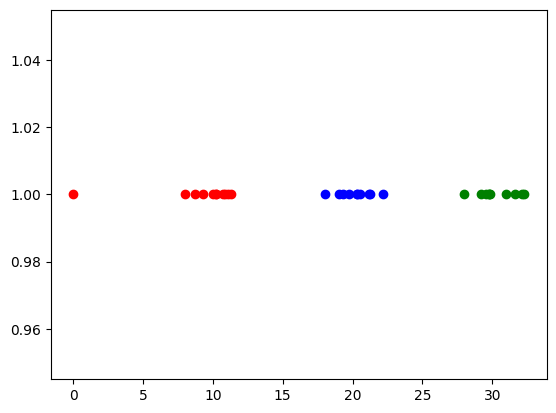

In [11]:
plt.scatter(np.array(tpc[0]), np.ones((1, len(tpc[0]))), color ='red')
plt.scatter(np.array(tpc[1]), np.ones((1, len(tpc[1]))), color = 'blue')
plt.scatter(np.array(tpc[2]), np.ones((1, len(tpc[2]))), color = 'green')

In [14]:
# Stage 2 test
f, trace = compute_fof(tpc)
print(f'trace map: {trace}')

trace map: {10.887466215619538: 0.02316492776176233, 10.207656712689845: 0.04072112498749428, 8.030892925408693: 0.24528555890258993, 10.03000967506584: 0.057415754832305585, 10.696436269988752: 0.005212620342314243, 11.09295617159828: 0.04247613496102093, 9.278738317620904: 0.1280175357192911, 8.737419928316768: 0.17888869157131992, 11.32014100718772: 0.06382614893956816, 10.252116519703703: 0.036542952184865966, 0.0: 1.0, 18.010220515599716: 0.16337892608669116, 19.707033971250198: 0.08455757605006792, 19.060474528095167: 0.11459192544699093, 20.34393133195667: 0.0549720552384112, 20.338525339151712: 0.05522317751101945, 22.17109155915196: 0.029904237651160154, 19.27754718102307: 0.10450834230305037, 21.23543487362171: 0.013559422351473626, 20.50592913298754: 0.04744684064413969, 21.1754727918811: 0.01634481529968636, 29.77109721301954: 0.0625481074043653, 29.75329184560909: 0.06310877452583058, 27.938788339994723: 0.12024505449859944, 30.973274975835448: 0.024693143211265152, 31.654

In [16]:
#Stage 4 test

#create links data